## ISA Create - Sample Assay Plan as a Graph: Mass Spectrometry
Here I am showing how from a JSON-like dictionary describing an MS experiment you can create a full SampleAssayPlan as a graph and visualize how this looks like


In [314]:
from isatools.model import *
from isatools.create.models import *
import networkx as nx
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pydot
from graphviz import Digraph
import pygraphviz

In [315]:
%matplotlib inline

In [316]:
# from: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
# NOTE: This was commented out for testing with ISA-API output (a DiGraph)   
#     if not nx.is_tree(G):
#         raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


Here we define the structure of our sampling and assay plan, using a Python dictionary. From it we create a full `isatools.create.models.SampleAssayPlan` object

In [317]:
ms_assay_dict = OrderedDict([
            ('sample', [
                {
                    'node_type': SAMPLE,
                    'characteristics_category': 'organism part',
                    'characteristics_value': 'liver',
                    'size': 1,
                    'technical_replicates': None,
                    'is_input_to_next_protocols': True
                },
                {
                    'node_type': SAMPLE,
                    'characteristics_category': 'organism part',
                    'characteristics_value': 'blood',
                    'size': 5,
                    'technical_replicates': None,
                    'is_input_to_next_protocols': True
                },
                {
                    'node_type': SAMPLE,
                    'characteristics_category': 'organism part',
                    'characteristics_value': 'heart',
                    'size': 1,
                    'technical_replicates': None,
                    'is_input_to_next_protocols': True
                }
            ]),
            ('extraction', {}),
            ('extract', [
                {
                    'node_type': SAMPLE,
                    'characteristics_category': 'extract type',
                    'characteristics_value': 'polar fraction',
                    'size': 1,
                    'technical_replicates': None,
                    'is_input_to_next_protocols': True
                },
                {
                    'node_type': SAMPLE,
                    'characteristics_category': 'extract type',
                    'characteristics_value': 'lipids',
                    'size': 1,
                    'technical_replicates': None,
                    'is_input_to_next_protocols': True
                }
            ]),
            ('labeling', {}),
            ('labeled_extract', [
                {
                    'node_type': SAMPLE,
                    'characteristics_category': 'labeled extract type',
                    'characteristics_value': '',
                    'size': 2,
                    'technical_replicates': None,
                    'is_input_to_next_protocols': True
                }
            ]),
            ('mass_spectrometry', {
                'instrument': ['Agilent QTQF §'],
                'injection_mode': ['FIA', 'LC'],
                'acquisition_mode': ['positive mode']
            }),
            ('raw_spectral_data_file', [
                {
                    'node_type': DATA_FILE,
                    'size': 1,
                    'technical_replicates': 2,
                    'is_input_to_next_protocols': False
                }
            ])
        ])
ms_assay_plan = SampleAndAssayPlan.from_sample_and_assay_plan_dict(ms_assay_dict)

pv_combination: ()
count: 0, prev_node: sample_000
count: 1, prev_node: sample_001
count: 2, prev_node: sample_002
count: 0, prev_node: extraction_000_000
count: 1, prev_node: extraction_000_001
count: 2, prev_node: extraction_000_002
count: 0, prev_node: extraction_000_000
count: 1, prev_node: extraction_000_001
count: 2, prev_node: extraction_000_002
pv_combination: ()
count: 0, prev_node: extract_000_000
count: 1, prev_node: extract_000_001
count: 2, prev_node: extract_000_002
count: 3, prev_node: extract_001_000
count: 4, prev_node: extract_001_001
count: 5, prev_node: extract_001_002
count: 0, prev_node: labeling_000_000
count: 1, prev_node: labeling_000_001
count: 2, prev_node: labeling_000_002
count: 3, prev_node: labeling_000_003
count: 4, prev_node: labeling_000_004
count: 5, prev_node: labeling_000_005
pv_combination: ('Agilent QTQF §', 'FIA', 'positive mode')
count: 0, prev_node: labeled_extract_000_000
count: 1, prev_node: labeled_extract_000_001
count: 2, prev_node: labele

The `ms_assay_plan` object is a graph. Let's which are its `nodes`.

In [318]:
nx_graph = ms_assay_plan.as_networkx_graph()
# set(nx_graph.nodes)
nx_graph.number_of_nodes()

48

Here we print the `links` or `edges` of the graph

In [319]:
# set(nx_graph.edges)
nx_graph.number_of_edges()

45

In [320]:
nx_graph.size()

45

We output is as a `networkx` graph and we visualize it using `matplotlib`

In [321]:
G=nx_graph

In [322]:
# nx.draw(G)

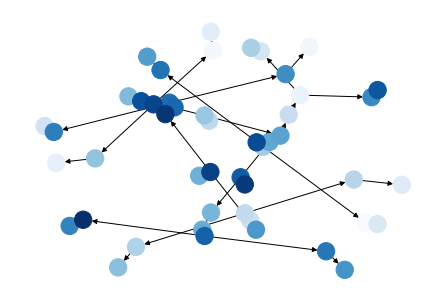

In [323]:
nx.draw(nx_graph,pos=nx.spring_layout(G),node_color=range(G.number_of_nodes()),cmap=plt.cm.Blues, with_labels=False)


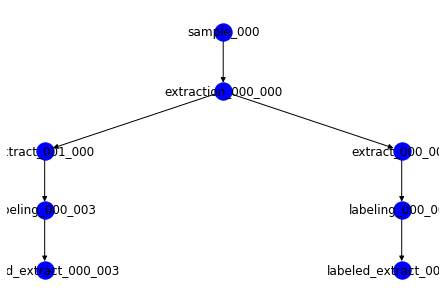

In [347]:
SG1 = G.subgraph(['sample_000','extraction_000_000','extract_000_000','extract_001_000','labeling_000_000','labeling_000_003','labeled_extract_000_000','labeled_extract_000_003'])
# print(list(SG.edges))
pos1 = hierarchy_pos(SG1,'sample_000')    
nx.draw(SG1, pos=pos1, with_labels=True,node_color = 'b')
plt.savefig('hierarchy1.png')


# SG2 = G.subgraph(['sample_001','extraction_000_001','extract_000_001','extract_001_001','labeling_000_001','labeling_000_004','labeled_extract_000_001','labeled_extract_000_004'])
# # print(list(SG.edges))
# pos2 = hierarchy_pos(SG2,'sample_001')    
# nx.draw(SG2, pos=pos2, with_labels=True,node_color = 'pink')
# plt.savefig('hierarchy2.png')


In [334]:
# Generating a graphviz compatible output
dot = Digraph()
for node in nx_graph.nodes:
    dot.node(node)
dot.edges(nx_graph.edges)
filename=dot.filename
# print(dot.source)
dot.graph_attr['rankdir'] = 'LR' # to layout from left to right (horizontal), rather than top to bottom (vertical)
dot.render(filename, view=True)

'Digraph.gv.pdf'

In [304]:
# nx.draw_networkx_edges(nx_graph,pos=nx.spring_layout(nx_graph))
# fig = go.Figure(data=[nx_graph.nodes,nx_graph.edges])

In [305]:
# nx.draw(nx_graph, with_labels=False, font_weight='bold')

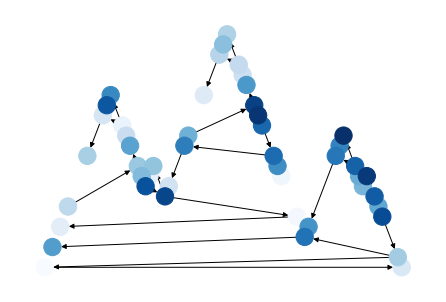

In [306]:
nx.drawing.draw_planar(nx_graph,node_color=range(G.number_of_nodes()),cmap=plt.cm.Blues, style='dashed')

In [307]:
nx.nx_agraph.to_agraph(nx_graph).layout()

In [308]:
nx.nx_agraph.to_agraph(nx_graph).write("isa-test.dot")

In [309]:
G=nx.nx_agraph.read_dot("isa-test.dot")

In [310]:
# G = nx.bipartite.gnmk_random_graph(3, 5, 10, seed=123)
# top = nx.bipartite.sets(G)[3]
# pos = nx.bipartite_layout(G, top)
# pos = nx.planar_layout(G)

In [311]:
pos=nx.drawing.layout.planar_layout(G, scale=2, center=None, dim=2)

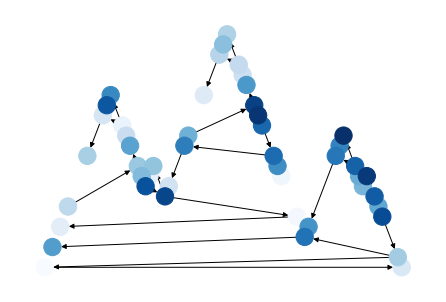

In [312]:
nx.draw(nx_graph,pos=nx.drawing.layout.planar_layout(G, scale=1, center=None, dim=2),node_color=range(G.number_of_nodes()),cmap=plt.cm.Blues)

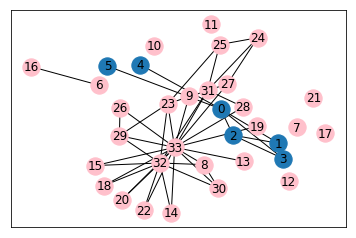

In [313]:
NG = nx.karate_club_graph()
res = [0,1,2,3,4,5, 'parrot'] #I've added 'parrot', a node that's not in G
                              #just to demonstrate that G.subgraph is okay
                              #with nodes not in G.
k = NG.subgraph(res)          
pos = nx.spring_layout(NG)  #setting the positions with respect to G, not k.

plt.figure()
nx.draw_networkx(k, pos=pos)

othersubgraph = NG.subgraph(range(6,NG.order()))
nx.draw_networkx(othersubgraph, pos=pos, node_color = 'pink')

plt.show()